<a href="https://colab.research.google.com/github/Matheus-P/Text-Verisimilitude-Verification-Using-Machine-Learning/blob/main/Text_Verisimilitude_Verification_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import csv
import pandas as pd
import numpy as np
import time
import math
import os
import io
import sys
import imp
import torch
from torch.nn import Linear, ReLU, CrossEntropyLoss, L1Loss, Sequential, Conv2d, MaxPool2d, Module
from torch.optim import Adam

import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model')

import data

! pip install pytorch_pretrained_bert transformers

     |████████████████████████████████| 123 kB 5.2 MB/s 
     |████████████████████████████████| 2.9 MB 26.1 MB/s 
     |████████████████████████████████| 131 kB 64.1 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 
     |████████████████████████████████| 3.3 MB 52.0 MB/s 
     |████████████████████████████████| 895 kB 52.1 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 8.0 MB 22.5 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 138 kB 69.0 MB/s 
     |████████████████████████████████| 127 kB 61.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take in

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text Generation

In [ ]:
! pip install -r /content/drive/MyDrive/Colab\ Notebooks/TCC/text-generation/requirements.txt

     |████████████████████████████████| 1.2 MB 3.8 MB/s 


In [ ]:
for i in range(1,1000):
  print(f"run number {i}")
  tstring = corpus.dictionary.idx2word[np.random.randint(0,len(corpus.dictionary.idx2word))]
  !python /content/drive/MyDrive/Colab\ Notebooks/TCC/text-generation/run_generation.py --length 700 --prompt $tstring --num_return_sequences 10 >> $bash_path/test_out.txt

In [ ]:
with open(path+'/data/wikitext-2/test_out.txt','r') as f:
  data = f.read()

data = data.replace('<|endoftext|>','')

with open(path+'/data/wikitext-2/out.txt','w') as f:
  f.write(data)

In [ ]:
data = data.replace('<|endoftext|>','')

In [ ]:
with open(path+'/data/wikitext-2/out.txt','w') as f:
  f.write(data)

In [ ]:
sum(1 for line in open(path+'/data/wikitext-2/out.txt'))

275524

In [ ]:
tr = open(path+'/data/wikitext-2/out_train.txt','x')
te = open(path+'/data/wikitext-2/out_test.txt','x')
va = open(path+'/data/wikitext-2/out_valid.txt','x')

count = 0

for line in open(path+'/data/wikitext-2/out.txt'):
  count += 1
  if count <= 220419:
    tr.write(line)
  elif (count > 220419 and count <= 247971):
    te.write(line)
  else:
    va.write(line)

tr.close()
te.close()
va.close()

# Model 1 (SC-Net)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model'
bash_path = '/content/drive/MyDrive/Colab\ Notebooks/TCC/word_language_model'

In [ ]:
! python $bash_path/main.py --nlayers 1 --data $bash_path/data/wikitext-2/ --epochs 3 --save $bash_path/saved/gru.pt

In [ ]:
GRUmodel = torch.load(path+'/saved/gru.pt',map_location=torch.device('cpu'))

In [ ]:
for param in GRUmodel.state_dict():
    print(param)

embed.weight
gru.weight_ih_l0
gru.weight_hh_l0
gru.bias_ih_l0
gru.bias_hh_l0
gru.weight_ih_l0_reverse
gru.weight_hh_l0_reverse
gru.bias_ih_l0_reverse
gru.bias_hh_l0_reverse
out.weight
out.bias


In [ ]:
class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=(600,1), stride=1),
        )

        self.linear_layers = Sequential(
            Linear(400, 2)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x).to(device)
        #x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
CNNmodel = CNN()
# defining the optimizer
optimizer = Adam(CNNmodel.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    CNNmodel = CNNmodel.cuda()
    criterion = criterion.cuda()
    
print(CNNmodel)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(600, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=400, out_features=2, bias=True)
  )
)


In [ ]:
summary(CNNmodel.cuda(), (1,600,400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 600, 400]              10
              ReLU-2          [-1, 1, 600, 400]               0
         MaxPool2d-3            [-1, 1, 1, 400]               0
            Linear-4              [-1, 1, 1, 2]             802
Total params: 812
Trainable params: 812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.92
Forward/backward pass size (MB): 3.67
Params size (MB): 0.00
Estimated Total Size (MB): 4.58
----------------------------------------------------------------


In [ ]:
forward_weights = GRUmodel.state_dict[weight_hh_l0]
reverse_weights = GRUmodel.state_dict[weight_hh_l0_reverse]

In [ ]:
concat = torch.cat((forward_weights,reverse_weights),1).unsqueeze(0).unsqueeze(0)

In [ ]:
CNNmodel(concat).squeeze(0).squeeze(0).squeeze(0)

tensor([-0.3520, -0.3140], grad_fn=<SqueezeBackward1>)

# Model 2 (SVM)

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TCC/A-Reversed-Turing-Test-for-Classifying-Inauthentic-Texts-master')
path = '/content/drive/MyDrive/Colab Notebooks/TCC/A-Reversed-Turing-Test-for-Classifying-Inauthentic-Texts-master'
bash_path = '/content/drive/MyDrive/Colab\ Notebooks/TCC/A-Reversed-Turing-Test-for-Classifying-Inauthentic-Texts-master'

In [ ]:
! python $bash_path/tfidf_all.py --mode train --save $bash_path/model.pkl --path $bash_path/Human-Machine.csv

0
f1: 0.98970398287403937854
1
f1: 0.98385340730307002666
2
f1: 0.98016872346212968736
3
f1: 0.98678249379982174716
4
f1: 0.98750090330865958332
5
f1: 0.98898262414562765343
6
f1: 0.98824514972563726189
7
f1: 0.98603756201618164567
8
f1: 0.98971971739986130956
9
f1: 0.98899372023900711248
f1_mean: 0.98699882842740349620


In [ ]:
test_string = 'am feeling some memeory upsurge and cpu downtime becuase of low system requirments}'

In [ ]:
! python $bash_path/main.py --mode predict --load $bash_path/model.pkl --sample "$test_string"

[0.]


# Model 3 (GLTR)

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/TCC/detecting-fake-text-master')
path = '/content/drive/MyDrive/Colab Notebooks/TCC/detecting-fake-text-master'
bash_path = '/content/drive/MyDrive/Colab\ Notebooks/TCC/detecting-fake-text-master'

In [ ]:
test_string = 'am feeling some memeory upsurge and cpu downtime becuase of low system requirments}'

In [ ]:
out = !python $bash_path/main.py --k 5 --sample "$test_string"

In [ ]:
out[0][out[0].find('bert'):].split()[1::2]

['0.12', '0.27', '0.19']

# Modelo Final


In [ ]:
from torchtext.data.datasets_utils import (
    _RawTextIterableDataset,
    _wrap_split_argument,
    _find_match
)

NUM_LINES = {
    'train': 36718,
    'valid': 4358,
    'test': 3760,
    'generated_train': 220419,
    'generated_valid': 27553,
    'generated_test': 27552
}

DATASET_NAME = "WikiText2"

def read_text_iterator(path, label):
    with io.open(path, encoding="utf8") as f:
        for row in f:
            yield row, label

@_wrap_split_argument(('train', 'valid', 'test', 'generated_train',
                       'generated_valid', 'generated_test'))
def WikiText2(root, split):
    files = os.listdir(root)
    path = _find_match(split, files)
    label = 1 if 'generated' in split else 0
    fullpath = os.path.join(root,path)
    return _RawTextIterableDataset(DATASET_NAME,
                                   NUM_LINES[split],
                                   read_text_iterator(fullpath,label))

In [ ]:
class Model(Module):   
  def __init__(self, path_to_saved_GRU, path_to_SVM, path_to_GLTR):
    super(Model, self).__init__()
    self.cnn = CNN().to(device),
    self.gru_path = path_to_saved_GRU,
    self.svm = os.path.join(path_to_SVM,'main.py'),
    self.svm_path = path_to_SVM,
    self.gltr = os.path.join(path_to_GLTR,'main.py'),
    self.linear_layers = Sequential(
        # Output of CNN (2), Output of SVM, Output of GLTR (2)
        Linear(5, 1)
    )

  # Defining the forward pass    
  def forward(self, string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # SC-Net
    gru_model = torch.load(self.gru_path[0]+'/saved/gru.pt',
                           map_location=torch.device(device))
    for param in gru_model.parameters():
      param.requires_grad_(False)
    hidden_weights = torch.stack((gru_model.state_dict()['gru.weight_hh_l0'], 
                                  gru_model.state_dict()['gru.weight_hh_l0_reverse']))
    
    _ , out_gru = gru_model(prepare_input(self.gru_path[0],string),
                            hidden_weights)
    cnn_input = torch.cat((out_gru[0],out_gru[0]),1).unsqueeze(0).unsqueeze(0)
    out_cnn = self.cnn[0](cnn_input.to(device))

    # SVM
    svm = self.svm[0].replace(' ','\ ')
    svm_path = self.svm_path[0].replace(' ','\ ')
    out_svm = !python $svm --mode predict --load $svm_path/model.pkl --sample "$string"

    # GLTR
    gltr = self.gltr[0].replace(' ','\ ')
    out = !python $gltr --k 5 --sample "$string"
    out_gltr = out[-1][out[-1].find('bert'):].split()[1::2]

    out_cnn = out_cnn.squeeze(0).squeeze(0).squeeze(0).to(device)
    out_svm = torch.tensor(eval(out_svm[0])).to(device)
    try:
      out_gltr = torch.tensor([float(out_gltr[0]),
                              float(out_gltr[1])]).to(device)
    except IndexError:
      out_gltr = torch.tensor([0.,0.]).to(device)

    x = torch.cat((out_cnn,out_svm,out_gltr),0)
    x = self.linear_layers(x)
    return x

In [ ]:
def prepare_input(path_to_data,string):
  corpus = data.Corpus(path_to_data+'/data/wikitext-2/','human')
  ids = []
  for word in string.split():
    if word in corpus.dictionary.word2idx.keys():
      ids.append(corpus.dictionary.word2idx[word])
    else:
      #ids.append(corpus.dictionary.word2idx['<unk>'])
      continue
  for i in range(0,600-len(ids)):
    ids.append(corpus.dictionary.word2idx['<eos>'])
  ids = torch.unsqueeze(torch.tensor(ids).to(device),0)
  return ids

In [ ]:
file_list = ['valid.txt',
             'test.txt',
             'train.txt',
             'generated_valid.txt',
             'generated_test.txt',
             'generated_train.txt']

In [ ]:
def prepare_file(filename):
  with open(wikitext_path+'/Raw_files/'+filename,'r') as f:
    lines = f.readlines()
  with open(wikitext_path+'/'+filename,'x') as f_out:
    for line in lines:
      if len(line) > 5:
        line = line.replace('<unk>','')
        line = line.replace('\"','')
      f_out.writelines(line)

In [ ]:
for filename in file_list:
  prepare_file(filename)

In [ ]:
GRU_path = '/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model'
SVM_path = '/content/drive/MyDrive/Colab Notebooks/TCC/A-Reversed-Turing-Test-for-Classifying-Inauthentic-Texts-master'
GLTR_path = '/content/drive/MyDrive/Colab Notebooks/TCC/detecting-fake-text-master'
wikitext_path = '/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model/data/wikitext-2'

In [ ]:
CompleteModel = Model(GRU_path,SVM_path,GLTR_path).to(device)
criterion = L1Loss()
optimizer = Adam(CompleteModel.parameters(),lr=0.00001)

dataset_human = WikiText2(wikitext_path,'train')
dataset_generated = WikiText2(wikitext_path,'generated_train')
dataset = dataset_human+dataset_generated
losses = []

def train(epochs):
  try:
    checkpoint = torch.load(wikitext_path+'/model.ckpt')
    CompleteModel.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_ckpt = checkpoint['epoch']
    losses = checkpoint['losses']
    iter = checkpoint['iter']
  except FileNotFoundError:
    print('Checkpoint not found!')

  CompleteModel.train()
  
  for epoch in range(1,epochs+1):
    for i, (line, label) in enumerate(dataset):
      if iter:
        if i < iter or epoch < epoch_ckpt:
          continue

      start = time.time()

      CompleteModel.zero_grad()
      print(line)
      output = CompleteModel(line)

      loss = criterion(output, torch.tensor(label).unsqueeze(0).to(device))
      CompleteModel.train()
      CompleteModel.cnn[0].train()
      loss.backward()
      optimizer.step()

      losses.append(loss)

      end = time.time()

      if i%50 == 0:
        torch.save({'epoch': epoch,
                    'iter': i,
                    'model_state_dict': CompleteModel.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'losses': losses}, wikitext_path+'/model.ckpt')
        
      print('| iter: {:3d}/{:3d} | epoch: {:3d}/{:3d} | loss: {:5.6f} | time: {:5.2f} |'.
            format(i,len(dataset),epoch,epochs,loss,end-start))

In [ ]:
train(1)

In [ ]:
iterg 3200
iter 3050

# Avaliação

In [ ]:
GRU_path = '/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model'
SVM_path = '/content/drive/MyDrive/Colab Notebooks/TCC/A-Reversed-Turing-Test-for-Classifying-Inauthentic-Texts-master'
GLTR_path = '/content/drive/MyDrive/Colab Notebooks/TCC/detecting-fake-text-master'
wikitext_path = '/content/drive/MyDrive/Colab Notebooks/TCC/word_language_model/data/wikitext-2'

In [ ]:
CompleteModel = Model(GRU_path,SVM_path,GLTR_path).to(device)
checkpoint = torch.load(wikitext_path+'/model.ckpt')
CompleteModel.load_state_dict(checkpoint['model_state_dict'])
losses = checkpoint['losses']

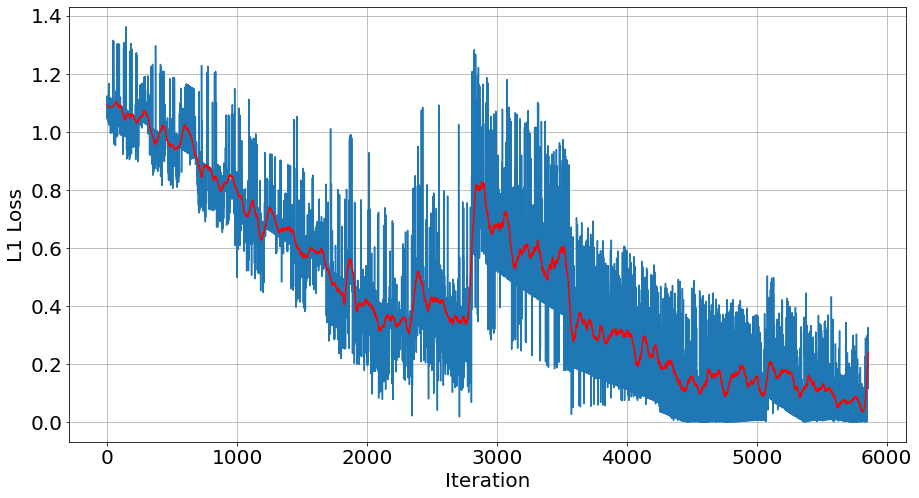

In [ ]:
from scipy.signal import savgol_filter

y = losses

yhat = savgol_filter(y, 101, 3) # window size 101, polynomial order 3

x = list(range(0,len(y)))

plt.figure(figsize=(15,8))
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.grid()
plt.ylabel('L1 Loss',fontsize = 20)
plt.xlabel('Iteration',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
class Precision:
    """
    Computes precision of the predictions with respect to the true labels.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of precision score
    """

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon

    def __call__(self, y_pred, y_true):
        y_pred = torch.tensor(y_pred,dtype=int)
        y_true = torch.tensor(y_true,dtype=int)
        true_positives = torch.sum(y_pred * y_true)
        predicted_positives = torch.sum(y_pred)
        precision = true_positives / (predicted_positives + self.epsilon)
        return precision


class Recall:
    """
    Computes recall of the predictions with respect to the true labels.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of recall score
    """

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon

    def __call__(self, y_pred, y_true):
        y_pred = torch.tensor(y_pred,dtype=int)
        y_true = torch.tensor(y_true,dtype=int)
        true_positives = torch.sum(y_pred * y_true)
        actual_positives = torch.sum(y_true)
        recall = true_positives / (actual_positives + self.epsilon)
        return recall


class F1Score:
    """
    Computes F1-score between `y_true` and `y_pred`.
    Args:
        y_true: Tensor of Ground truth values.
        y_pred: Tensor of Predicted values.
        epsilon: Fuzz factor to avoid division by zero. default: `1e-10`
    Returns:
        Tensor of F1-score
    """

    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon
        self.precision = Precision()
        self.recall = Recall()

    def __call__(self, y_pred, y_true):
        y_pred = torch.tensor(y_pred,dtype=int)
        y_true = torch.tensor(y_true,dtype=int)
        precision = self.precision(y_pred, y_true)
        recall = self.recall(y_pred, y_true)
        return 2 * ((precision * recall) / (precision + recall + self.epsilon))

In [ ]:
score = F1Score()
precision = Precision()
recall = Recall()

print(score(preds,labels),precision(preds,labels),recall(preds,labels))

tensor(0.4407) tensor(0.2939) tensor(0.8798)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

In [ ]:
0def binary_step(x):
  if x<0:
    return 0
  else:
    return 1

In [ ]:
dataset_human = WikiText2(wikitext_path,'test')
dataset_generated = WikiText2(wikitext_path,'generated_test')
dataset = dataset_human+dataset_generated
print(len(dataset_human)//2,len(dataset_generated)//24,len(dataset_human)//2+len(dataset_generated)//24)

1880 1148 3028


In [ ]:
print(len(dataset_human))

3760


In [ ]:
3760+1148 

4908

In [ ]:
predictions = torch.load(wikitext_path+'/predictions.pt')
preds = predictions['preds']
labels = predictions['labels']

In [ ]:
preds = []
labels = []

In [ ]:
print(len(preds),len(labels))

2322 2322


In [ ]:
def evaluate():
  dataset_human = WikiText2(wikitext_path,'test')
  dataset_generated = WikiText2(wikitext_path,'generated_test')
  dataset = dataset_human+dataset_generated

  CompleteModel.eval()

  for i, (line, label) in enumerate(dataset):
    if i < 1401 :
      continue
    if i > len(dataset_human)//2 and i < len(dataset_human):
      continue
    elif i > len(dataset_human)+len(dataset_generated)//24:
      break
    else:
      out = CompleteModel(line)
      pred = binary_step(float(out))
      preds.append(pred)
      labels.append(label)
      print(i)
    if i % 50 == 0:
      torch.save({'preds': preds,
                  'labels': labels},wikitext_path+'/predictions.pt')

In [ ]:
evaluate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600


SyntaxError: ignored

In [ ]:
print(list(zip(preds,labels)))

[(0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0),

In [ ]:
import sklearn.metrics as sm
sm.roc_auc_score(labels,preds)

0.6921687335221169

In [ ]:
sm.f1_score(labels,preds)

0.4406587166382737

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
perf_measure(labels,preds)

(388, 932, 949, 53)

In [ ]:
sm.balanced_accuracy_score(labels,preds)

0.6921687335221169